# Lab exercise #3: Approximate inference for Gaussian Process models

CS-E4075, 2021

## Learning objectives

After completing this lab exercise, you should be able to:

- Implement Variational inference for GP classification


**/!\ Important Notes /!\**
* In this notebook, we **won't** be implementing sparse GPs (the approximation using inducing points). However, completing this notebook will give you all the tools and building blocks to implement them.
* For speed purposes, it is highly recommended to use an automatic differentiation framework such as tensorflow or pytorch. (optimization using numpy/scipy also works, but will be much slower!). Examples and hints in this notebook are using tensorflow but can be adapted to run in alternative frameworks.
* All exercises must be solved using only basic mathematical operations (exp, erf, ...) and linear algebra routines (solve, matrix-vector products, ...)



**A mini tutorial on automatic differentiation**

When using an automatic differentiation framework to optimize a function $f: \theta \to f(\theta)$, the variable $\theta$ and/or the operations mapping from $\theta$ to $f(\theta)$ must be defined using operators from the framework.

For example to optimize $e^{\theta}+e^{-\theta}$ with respect to $\theta$ with tensorflow, you need to proceed as follows:


In [1]:
import tensorflow as tf

# define the theta variable
theta = tf.Variable(1., dtype=tf.float32)
# define the function
f = lambda x: tf.exp(x) + tf.exp(-x) # note the use of the tf.exp operation (not np.exp)
# run the optimization
for t in range(1000):
  # at each step, compute the gradients
  with tf.GradientTape() as tape:
    tape.watch(theta)
    loss = f(theta)
  gradient = tape.gradient(loss, theta)
  # apply the variable update (gradient descent)
  theta.assign(theta - 0.01*gradient)
  if t % 100 == 0:
    print(t, theta)   

0 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.976496>
100 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1199726>
200 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.015891422>
300 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0021074635>
400 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0002794935>
500 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.706653e-05>
600 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.913991e-06>
700 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=6.492792e-07>
800 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=8.5419515e-08>
900 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.9391202e-08>


In [2]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf


import tensorflow_probability as tfp
tfb = tfp.bijectors
b = tfb.FillScaleTriL(diag_bijector=tfb.Exp())

## Task 1: Variational inference for Gaussian Process Classification

We are interested in the problem of Gaussian Process classification. 

We have some data $\mathcal{D} = \left\lbrace {\bf x}_n, y_n \right\rbrace_{n=1}^N$, with $y_n \in \{-1,1\}$.

We want to perform inference in the following generative model
$$ f \sim GP(0, k)$$
$$ p(y_n=1|{\bf x}_n) = \phi(y_n * f_n),$$
with $\phi$ the normal cumulative distribution function $\phi(x)=\int_{-\infty}^x {\cal N}(u; 0,1)du$.

We will here use a RBF kernel, with two parameters: lengthscale $l$ and variance $\sigma^2$.


The posterior is $p({\bf f}|{\bf y}) \propto p({\bf y}|{\bf f})p({\bf f})$ is intractable, hence we resort to an approximate inference scheme called variational inference.

This turns inference into optimization. We optimize the distance $d(q) = KL[q({\bf f})||p({\bf f}|{\bf y})] \geq 0$, with respect to a distribution $q({\bf f})$

We parameterize $q$ through the mean vector $m$ and the Cholesky factor of the covariance $L$: i.e. $q({\bf f})={\cal N}({\bf f}|m, S=LL^T)$

In practice we optimize the ELBO:
$${\cal L}(q) = \log p({\bf y})-d(q) = 
\underbrace{\mathbb{E}_q \log p({\bf y}|{\bf f})}_{VE} 
- \underbrace{KL(q({\bf f})||p({\bf f}))}_{KL}$$

We split the ELBO into two terms
* variational expectations (VE)
* Kullback Leibler (KL)


### Task 1a: KL divergence

For a prior $p({\bf f})={\cal N}({\bf f}|0,K)$ and a variational distribution $q({\bf f})={\cal N}({\bf f}|m, S=LL^T)$, compute the KL divergence $KL(q({\bf f})||p({\bf f}))$

You can use the formula :
$$
\begin{align*}
&KL\left(\mathcal{N}(\mu_0,\Sigma_0) \parallel \mathcal{N}(\mu_1,\Sigma_1)\right) \\ 
 &= \frac{1}{2}\left(
    \operatorname{tr}\left(\Sigma_1^{-1}\Sigma_0\right) +
    \left(\mu_1 - \mu_0\right)^\mathsf{T} \Sigma_1^{-1}\left(\mu_1 - \mu_0\right) - k +
    \ln\frac{|\Sigma_1|}{|\Sigma_0|}
  \right),\; (source: wikipedia)\\
  &= \dots \quad \text{ (bonus : can you fill the gap?)}\\
    &=
  \frac{1}{2}\left(
    \sum_{ij} (L_1^{-1}L_0)^2_{ij} +
    ||L_1^{-1}\left(\mu_1 - \mu_0\right)||^2 - k + 2\sum_{i}
    \ln |L_{1,ii}|- \ln|L_{0,ii}|
  \right).
  \end{align*}
  $$

**Note**: this needs to be adapted to the (mean,cholesky) parameterization of the multivariate Gaussian distributions.


In [3]:
def KL(m0, L0_const, m1, L1_const):
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N x 1, mean vector
    L0, L1   -- N x N, Cholesky factor of a covariance matrix 
    returns a scalar
    """
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    #############!! SOLUTION !!####################
    L0 = b.forward(L0_const)
    L1 = b.forward(L1_const)

    N = len(m1)
    iL1L0 = tf.linalg.triangular_solve(L1, L0)
    term1 = tf.reduce_sum(iL1L0**2)
    
    iL1dmu = tf.linalg.triangular_solve(L1,m1 - m0)
    term2 = tf.reduce_sum(iL1dmu**2)
    cst = -N
    
    term3 = 2 * tf.reduce_sum(tf.abs(tf.linalg.diag_part(L1)) -
                 tf.abs(tf.linalg.diag_part(L0)))
    
    return 0.5 * (term1 + term2 + term3 + cst)
    #############!! SOLUTION !!####################


Let's check that the KL is coded properly.

For instance, noting $q_0(f) = N(f|0, I)$ and $q_1(f) = N(f|0, 2I)$, 
we should have:
* $KL[q_0||q_0] = 0$
* $KL[q_0||q_1] > 0$ 



In [4]:
K = 10
m_0 = m_1 = np.zeros((K,1))
L_0 = tf.constant(np.eye(K), dtype=tf.float32)
L_1 = tf.constant(np.sqrt(2.) * np.eye(K), dtype=tf.float32)

L_0_const = b.inverse(L_0)
L_1_const = b.inverse(L_1)

assert KL(m_0, L_0_const, m_0, L_0_const) == 0
assert KL(m_0, L_0_const, m_1, L_1_const) >= 0

### Task 1b: Variational expectations

To compute the variational expectations $\mathbb{E}_{q(f_n)} \log p(y_n|f_n)$, we first need to compute the marginal distribution $q(f_n)$ and then compute the expectation.


In [5]:
def q_marginals(m, L_const):
    """ returns the vectors of marginal means and marginal variances
    i.e, the means and variances of q(f_n)
    
    arguments:
    m   -- N x 1, mean vector
    L   -- N x N, Cholesky factor of a covariance matrix 
    returns : 2 N x 1 vectors
    """
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    #############!! SOLUTION !!####################
    L = b.forward(L_const)

    cii = tf.reduce_sum(L**2, axis=1, keepdims=True)
    return m, cii
    #############!! SOLUTION !!####################



In [6]:

def phi(x):
    """ Cumulative distribution function for the standard normal distribution 
    Hint: you may want to use the error function. (tf.math.erf if using tensorflow)

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    
    #############!! SOLUTION !!####################
    return (1.0 + tf.math.erf(x / np.sqrt(2.0))) / 2.0
    #############!! SOLUTION !!####################

def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    #############!! SOLUTION !!####################
    return tf.math.log(phi(f * y))
    #############!! SOLUTION !!####################
    
# --------------------------------------
# The next function is given to you.
# It approximates E_q(f_n) log p(y_n|f_n) via Gaussian quadrature
# see: https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature
# --------------------------------------
def expected_log_likelihood(
    means, covs, llh, y, n_gh=10):
    """ returns the expected log likelihood terms
    
    E_q(f_n) log p(y_n|f_n)
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    arguments:
    means  -- N x 1, vector of means
    covs  -- N x 1, vector of covariances 
    llh -- log likelihood function
    y  -- N x 1, vector of observed labels 
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 x n_gh 
    inputs = means + np.sqrt(2 * covs) * z.reshape(1, -1) # N x n_gh
    llh_quad = weights * llh(inputs, y) # N x n_gh

    # 'tf.reduce_sum' is tensorflow's summing function, 
    # replace if using another framework  
    return tf.reduce_sum(llh_quad, axis=1) # N, 

### Task 1c: ELBO

We are now ready to implement the ELBO as the difference between the variational expectations and the KL divergence:

$${\cal L}(q) = 
\underbrace{\mathbb{E}_q \log p({\bf y}|{\bf f})}_{VE} 
- \underbrace{KL(q({\bf f})||p({\bf f}))}_{KL}$$




In [7]:
def elbo(m_p, L_p_const, m_q, L_q_const, y):
    """ returns ELBO
    L = \sum_n E_q(f_n) log p(y_n|f_n)
        + KL(q(f)||p(f))
        
    (See slides of lecture 4 for closed form solution)
    
    arguments:
    L_p, L_q  -- N x N, Cholesky factors of the covariances of p and q
    m_p, m_q -- N x 1, mean vector of p and q
    returns: a scalar
    """
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    #############!! SOLUTION !!####################
    means, covs = q_marginals(m_q, L_q_const)
    ve = expected_log_likelihood(means, covs, classif_log_likelihood, y)
    kl = KL(m_q, L_q_const, m_p, L_p_const)
    return tf.reduce_sum(ve) - kl
    #############!! SOLUTION !!####################

    

### Task 1d: Inference as optimization

We are now ready to optimize the ELBO.
We will first load some data

Text(0.5, 1.0, 'Classification data')

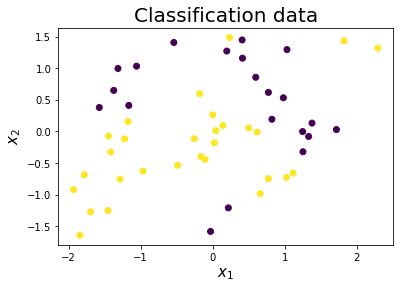

In [8]:
# Loading the data

import csv
XY = []
with open("./XY.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)
XY = np.array(XY)

# Here we select a subset of the data. (remember computations scales as N^3)
N = 50
X, Y = XY[:N,:-1],XY[:N,-1:]
Y = (Y-.5) * 2 # to be in {-1, 1}
N = X.shape[0]

# Plotting the data

plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20)

#### Preparing prior statistics

We need to compute the prior covariance $K_p = K_{\bf ff}$ and its Cholesky factor $L_p = chol(K_{\bf ff})$.

In [9]:
# kernel parameters
l = 0.5
s = 0.5 # the standart deviation

# computing the kernel matrix K_ff

###############################################
# ------- insert code here -------------------
###############################################

#############!! SOLUTION !!####################
dists = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=-1)
K_p = tf.cast(
    s**2 * tf.exp(- 0.5 * dists**2 / l**2),
    dtype=tf.float32
)
#############!! SOLUTION !!####################

# Computing m_p, L_p = cholesky(K_p).

###############################################
# ------- insert code here -------------------
###############################################

#############!! SOLUTION !!####################
m_p = tf.zeros((N, 1), dtype=tf.float32)
jitter = 1.e-6
L_p = tf.linalg.cholesky(K_p + np.eye(N) * jitter) # jitter sometimes needed.
L_p_const = b.inverse(L_p)
#############!! SOLUTION !!####################



We initialize the variational distribution to $q({\bf f})={\cal N}({\bf f};0, I)$,
then optimize the ELBO using gradient based optimization.


Gradient based optimization refers to optimization schemes where a function $f(\theta)$ is optimized with respect to $\theta$ by following the gradient $\nabla_{\theta} f(\theta)$.
For example gradient descent construct a sequence of values $\theta_t$ following
$$\theta_{t+1 } = \theta_t + \eta \nabla_{\theta} f(\theta)|_{\theta=\theta_t}$$
where $\eta$ is the learning rate.


When using an automatic differentiation framework, one does not need to manually derive the gradient (hence the 'automatic'). Such frameworks include tensorflow, jax, pytorch (pick your favorite). These are widely used to optimize the loss function of neural network models in supervised learning.

In [24]:
# initial distribution parameters m_q, L_q
m_q = tf.Variable(tf.zeros((N, 1), dtype=tf.float32))
L_q_const = tf.Variable(L_p_const.numpy(), dtype=tf.float32) # just copying the prior!



# Optimize the loss: a tensorflow routine is given
loss = lambda m, L_const: - elbo(m_p, L_p_const, m, L_const, Y)


# definition of a training step
def train(opt, m, L_const):
    with tf.GradientTape() as tape:
        tape.watch([m, L_const])
        loss_ = - elbo(m_p, L_p_const, m, L_const, Y)
    gradients = tape.gradient(loss_, [m, L_const])
    opt.apply_gradients(zip(gradients, [m, L_const]))

# you can change the optimizer or learning rate
opt = tf.optimizers.Adam(learning_rate=.005) 

# running the optimization
for t in range(1000):
    train(opt, m_q, L_q_const)
    if t % 100 == 0:
        print(t, loss(m_q, L_q_const))   


0 tf.Tensor(43.967033, shape=(), dtype=float32)
100 tf.Tensor(25.733654, shape=(), dtype=float32)
200 tf.Tensor(20.25793, shape=(), dtype=float32)
300 tf.Tensor(17.320648, shape=(), dtype=float32)
400 tf.Tensor(15.554422, shape=(), dtype=float32)
500 tf.Tensor(14.420387, shape=(), dtype=float32)
600 tf.Tensor(13.681102, shape=(), dtype=float32)
700 tf.Tensor(13.172512, shape=(), dtype=float32)
800 tf.Tensor(12.809529, shape=(), dtype=float32)
900 tf.Tensor(12.536594, shape=(), dtype=float32)


* Plot the evolution of the ELBO as a function function of iterations.

* Plot the posterior process $p(f^*|x^*, {\cal D})$.

* Plot the predictive distribution $p(y^*=1|x^*)$.

* Repeat the procedure for different values of $(\sigma^2, l)$, can you see an improvement? Is the ELBO a good proxy for hyperparameter optimization in this example?


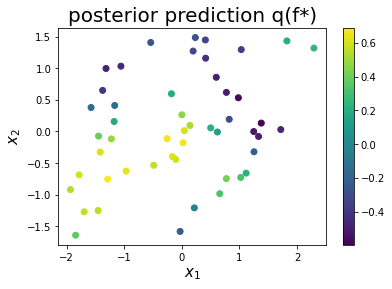

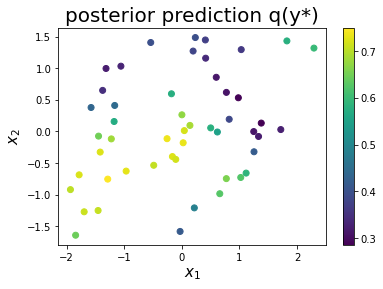

In [25]:
###############################################
# ------- insert code here -------------------
###############################################

#############!! SOLUTION !!####################
means_final, covs_final = q_marginals(m_q, L_q_const)
means_final = means_final.numpy()
covs_final = covs_final.numpy()
plt.scatter(X[:,0], X[:,1], c=means_final)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('posterior prediction q(f*)', fontsize=20)
plt.colorbar()
plt.show()

p_final = phi(means_final / np.sqrt(1 + covs_final))
plt.scatter(X[:,0], X[:,1], c=p_final)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('posterior prediction q(y*)', fontsize=20)
plt.colorbar()
plt.show()
#############!! SOLUTION !!####################


### Task 1e: Posterior prediction for new data points

Under the hood, the algorithm defines a posterior process for all values of the input space.

For a new input $x^*$, the posterior prediction is given by 

$
\begin{align*}
q(f(x^*)) &= \int p(f(x^*)|{\bf f})q({\bf f})d{\bf f}\\
 &= {\cal N}(f(x^*)| K_{f^*{\bf f} }K_{{\bf ff}}^{-1} m_q,
 K_{f^*f^*} - K_{f^*{\bf f}}K_{{\bf ff}}^{-1}(K_{{\bf ff}} - S)K_{{\bf ff}}^{-1}K_{{\bf f} f^*})
\end{align*}
$

In [26]:
def posterior_marginal_prediction(X_new, X, m_q, L_q_const):
  """ compute the posterior marginal predictions q(f(x*)) 
  independently for all inputs in X_new 
  
  arguments:
    X_new -- N_new x 2, matrix of new inputs
    X     -- N x 2, matrix of training inputs
    L_q   -- N x N, Cholesky factor of the covariances of q
    m_q   -- N x 1, mean vector of q
    returns: predictive marginal means and variances (both with size N_new x 1) 
  """


  ###############################################
  # ------- insert code here -------------------
  ###############################################

  #############!! SOLUTION !!###################
  L_q = b.forward(L_q_const)
  L_p = b.forward(L_p_const)

  dists = np.linalg.norm(X_new[:, None, :] - X[None, :, :], axis=-1)
  K_fnf = tf.cast(
    s**2 * tf.exp(- 0.5 * dists**2 / l**2),
    dtype=tf.float32
  )
  dists = tf.reduce_sum(X_new**2,  axis=1, keepdims=True)
  K_fnfn = tf.cast(
    s**2 * tf.exp(- 0.5 * dists**2 / l**2),
    dtype=tf.float32
  )

  V = tf.linalg.cholesky_solve(L_p, tf.transpose(K_fnf)) # K_ff^-1 K_ff*
  pred_means = tf.matmul(V, m_q, transpose_a=True)
  A =  tf.matmul(V, L_p, transpose_a=True) # chol(K_ff)^T K_ff^-1 K_ff*
  B =  tf.matmul(V, L_q, transpose_a=True) # chol(S)^T K_ff^-1 K_ff*
  pred_vars = (
      K_fnfn 
      - tf.reduce_sum(A**2, axis=1, keepdims=True)
      + tf.reduce_sum(B**2, axis=1, keepdims=True)
  )

  return pred_means, pred_vars
  #############!! SOLUTION !!###################


Plotting the prediction

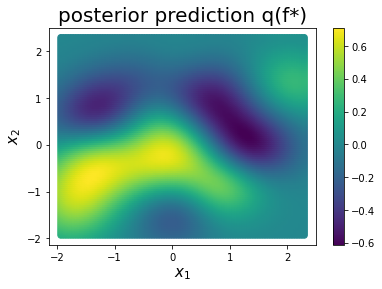

In [27]:
# create new input points on grid
n_grid = 100
x = np.linspace(X.min(), X.max(), n_grid)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([
  X1new.reshape(-1,1), X2new.reshape(-1,1)
])  # size : n_grid * n_grid x 2

###############################################
# ------- insert code here -------------------
###############################################
  
#############!! SOLUTION !!####################

# evaluate posterior process on grid
pred_means, pred_vars = posterior_marginal_prediction(Xnew, X, m_q, L_q_const)

plt.scatter(Xnew[:,0], Xnew[:,1], c=pred_means)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('posterior prediction q(f*)', fontsize=20)
plt.colorbar()
plt.show()

#############!! SOLUTION !!####################



### Advanced [for the curious, no extra points]
* Repeat the procedure for the regression setting with Gaussian noise. You need to derive new variational expectations since the likelihood changes. Apply the resulting algorithm to the regression problem of the previous assignment.
* For fixed hyperparameters, do the ELBO match the marginal likelihood $\log p({\bf y})$? If so why?

In [28]:
###############################################
# ------- insert code here -------------------
###############################################